# US COLLEGE DATASET 
## Classification tutorial


by *Ignacio Carracedo*


## SUMMARY

The Department places institutions on a Heightened Cash Monitoring (HCM) payment method to provide additional oversight of cash management. HCM2 is the type of HCM that indicates more serious financial or federal compliance issues including but not limited to accreditation issues, late or missing annual financial statements and/or audits, outstanding liabilities, denial of re-certifications, concern around the school's administrative capabilities, concern around a schools' financial responsibility, and possibly severe findings uncovered during a program review. Some schools are on this list due to preliminary findings made during a program review that is still open. Those findings could change when the program review is completed. 

A school placed on HCM2 no longer receives funds under the Advance Payment Method. After a school on HCM2 makes disbursements to students from its own institutional funds, a Reimbursement Payment Request must be submitted for those funds to the Department.

This notebook builds a model to look at what triggers a school to be on HCM2. 

**1.LOAD DATA** 

    1.1. Download the data 
    1.2. Concatenate the data   
    1.3. Look at the data structure
    1.4. Select a dataset to analyze 
    
**2. FEATURE SELECTION **

    2.1 Missing values
    2.2 Informative Variables
    2.3 Split data into training and test sets 
    2.4 Feature importance
    2.5 Correlation
      
**3.MODEL**

    3.1. Custom transformers    
    3.2. Pipeline    
    3.3. Model selection    
        3.3.1. Logistic regression
        3.3.2. Decision Tree
        3.3.3. SVM
        3.3.4. Random Forest
        3.3.5. Metrics
    3.5. Final model 
    3.6. Additional comments

First, we import all necesary libraries that will be use in this notebook:

In [18]:
import os
from os import listdir
from os.path import isfile, join
import zipfile
from six.moves import urllib

import itertools

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as sk_dt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

import warnings
warnings.filterwarnings('ignore')

## 1. LOAD DATA

### 1.1. Download the data

The college data set is located at 'https://collegescorecard.ed.gov/data/'. Data is compressed in a zip file that has a .csv file per school year.

In [19]:
""" Define the location of the data in the web and the 
    downloading location in our local project folder """
DOWNLOAD_ROOT = "https://ed-public-download.apps.cloud.gov/downloads/"
COLLEGE_PATH = "datasets/collegescorecard"
COLLEGE_URL = DOWNLOAD_ROOT+ "/CollegeScorecard_Raw_Data.zip"

The following function will:

* Download zipped dataset into datasets\collegescorecard\CollegeScorecard_Raw_Data folder.
* Extract the datasets from the zip file

In [ ]:
def fetch_housing_data(college_url=COLLEGE_URL, college_path=COLLEGE_PATH):
    """ downloads data from college_url and unzip it into college_path"""
    
    os.makedirs(college_path, exist_ok=True)
    zip_path = os.path.join(college_path, "CollegeScorecard_Raw_Data.zip")
    urllib.request.urlretrieve(college_url, zip_path)
    college_zip = zipfile.ZipFile(zip_path, 'r')
    college_zip.extractall(path=college_path)
    college_zip.close()
    
fetch_housing_data()

### 1.2. Concatenate the data 

There is one csv file for each school year, the following function reads the .csv files separately and concatenate them to one data frame. During this process a YEAR column is added to show the school year of each observation. The function also takes a string as an argument and will only concatenate files that have that string in their name. 

Because of memory issues, we pass the string *'201'* to the function to select a subset of the files, the ones for 2010 and after.

In [145]:
def load_college_data(college_path=COLLEGE_PATH+'/CollegeScorecard_Raw_Data', string_include = "" ):
    """ concatenates csv files into one data frame. Function accepts paramenter string to filter files"""
    college_list = []
    onlyfiles = [f for f in listdir(college_path) if (isfile(join(college_path, f)))
                 and (".csv" in f) and (string_include in f)]
    
    for f in onlyfiles:
        print("Reading %s ..." %f)
        csv_path = os.path.join(college_path, f)
        aux = pd.read_csv(csv_path,low_memory=False)
        aux['YEAR']=int(f.split('MERGED')[1].split('_')[0])
        college_list.append(aux)
        del aux 
    print("Concatenating files ...")
    return pd.concat(college_list)

In [146]:
#get a list of files in directory that are .csv in and after 2010
college = load_college_data(string_include="201")

Reading MERGED2010_11_PP.csv ...
Reading MERGED2011_12_PP.csv ...
Reading MERGED2012_13_PP.csv ...
Reading MERGED2013_14_PP.csv ...
Reading MERGED2014_15_PP.csv ...
Concatenating files ...


We now have a data frame (`college`) with years after 2010.

### 1.3. Look at the data structure

We can now check the size of the data frame and explore the first 5 rows to get a general idea of what it looks like

In [147]:
print("Rows: %s, Columns: %s " %(college.shape[0],college.shape[1]))
college.head()

Rows: 38389, Columns: 1744 


,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM,YEAR
0,100654,00100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0,2010
1,100663,00105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0,2010
2,100690,02503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0,2010
3,100706,00105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0,2010
4,100724,00100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0,2010


Let's check values of target variable for each year

In [148]:
for y in college.YEAR.unique():
    print("Values for year %s: " % (y))
    print(college[college['YEAR']==y]["HCM2"].value_counts())

Values for year 2010: 
Series([], Name: HCM2, dtype: int64)
Values for year 2011: 
Series([], Name: HCM2, dtype: int64)
Values for year 2012: 
Series([], Name: HCM2, dtype: int64)
Values for year 2013: 
Series([], Name: HCM2, dtype: int64)
Values for year 2014: 
0.0    7467
1.0     236
Name: HCM2, dtype: int64


Only 2014 has data, we'll use the data from that year.

### 1.4. Select a data set to analyze

A data frame containing 2014-2015 school year information is created below.

In [149]:
college2014 = college[college['YEAR']==2014] #filer
college2014.to_csv(COLLEGE_PATH+'/college2014.csv',index=False) # save
del college # delete to save memory

Next time we run the notebook we could start using the following cell that loads the data of 2014 back in. It will be faster.

In [4]:
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv',
                          encoding = "ISO-8859-1",
                          low_memory=False,na_values='PrivacySuppressed')


## 2. FEATURE SELECTION

### 2.1 Missing values

The next cell defines a function to return the data frame with all the columns that have a percentage of missing values below a threshold. We will use this function to select features to feed into our machine learning algorithm because the features with fewer missing values are likely to be more useful/important. And missing values affect the performance of  machine learning algorithms. 

Since HCM2 is the target variable, we decided to select the rows where HCM2 is not missing.

In [5]:
college2014 = college2014.dropna(axis=0, subset=["HCM2"])
print("Rows: %s, Columns: %s " %(college2014.shape[0],college2014.shape[1]))

Rows: 7703, Columns: 1744 


Actually there is no missing data for HCM2 in 2014 college data.
Then we would like to check the observation counts for each value of HCM2.

In [6]:
college2014["HCM2"].value_counts()

0.0    7467
1.0     236
Name: HCM2, dtype: int64

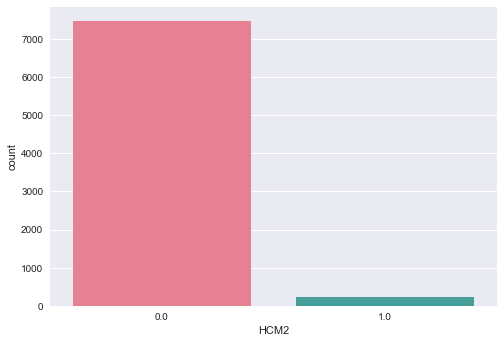

In [7]:
## show the counts visually
sns.countplot(x='HCM2',
              data=college2014, palette="husl")
plt.show()

236 out of 7703 institutions received HCM2. The event level is at the border line rare for the logistic regression method. 
We define a function to select variables according to its missing value percentage.

In [8]:
def cols_few_missing_values(df, threshold=0):
    
    '''this function takes a DataFrame and a threshold as parameters and 
       returns the DataFrame with the columns that have a percentage of
       missing values equal or less than the threshold'''

    columns = []
    total_rows = college2014.shape[0]
    missing_values = dict(college2014.isnull().sum())
    
    for key, value in missing_values.items():
        if (value/total_rows) <= threshold:
            columns.append(key)    
            
    df = df[columns]
    print("*** Keeping %s out of %s columns with missing values threashold of %s ***\n"
          %(len(columns), college2014.shape[1], threshold))
    return (df)

We decided to keep variables with less than 10% missing values.

In [9]:
cols_few_missing_values(college2014, threshold=0.1).columns

*** Keeping 296 out of 1744 columns with missing values threashold of 0.1 ***



Index(['CIP12CERT2', 'CIP11CERT2', 'CITY', 'CIP42CERT2', 'UGDS_ASIAN',
       'CIP30CERT4', 'CIP44CERT1', 'UGDS_HISP', 'CIP45CERT2', 'CIP42ASSOC',
       ...
       'PREDDEG', 'APPL_SCH_N', 'RELAFFIL', 'PCIP31', 'PCIP45', 'CIP54CERT2',
       'CIP29CERT4', 'CIP27ASSOC', 'CIP22CERT2', 'PCIP19'],
      dtype='object', length=296)

In [10]:
college2014 = college2014[cols_few_missing_values(college2014, threshold=0.1).columns]

*** Keeping 296 out of 1744 columns with missing values threashold of 0.1 ***



### 2.2 Informative Variables

Do the columns give us any information about the target variable? If a column only has one value, then it is not informative and will be deleted.

In [11]:
no_info = []
one_class_info = []

for col in college2014.columns:
    a = college2014.dropna(subset=[col])
    if a["HCM2"].value_counts().values.size == 0:
        no_info.append(col)
    elif a["HCM2"].value_counts().values.size == 1:
        one_class_info.append(col)
    del a
    
print("Dropping %s columns ... " % (len(no_info + one_class_info)))
college2014.drop(no_info + one_class_info, axis=1, inplace=True)

Dropping 0 columns ... 


At the end, there is no variable that contains only one value. 

### 2.3 Split data into training and test sets. 

In [12]:
def split(X):
    """this function takes the college dataframe as parameter and 
       returns train/test sets as a tuple. Stratify based on HCM2"""
    #stratified split based on CONTROL
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    for train_index, test_index in split.split(X, X["HCM2"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

train_set, test_set = split(college2014)

We will work with the training data only to build the model.

### 2.4 Feature importance

Drop the columns that are not relevent by domain knowledge or because we are not interested in using them:
* NPCURL: URL for institution's net price calculator
* CITY: city located
* INSTNM: Institution name
* LONGITUDE: Longitude
* LATITUDE: Latitude
* INSTURL: URL for institution's homepage
* STABBR: State postcode
* ZIP: zip code
* CCUGPROF: Carnegie Classification -- undergraduate profile
* OPEID: 8-digit OPE ID for institution 
* OPEID6: 6-digit OPE ID for institution
* UNITID: Unit ID for institution

In [13]:
# we know we don't want to use these columns
train_set.drop(["NPCURL","CITY","INSTNM","LONGITUDE",
                "LATITUDE","INSTURL","STABBR","ZIP",
                "CCUGPROF","OPEID","OPEID6","?UNITID"],
               axis=1,
               inplace=True)

# delete na just for feature selection
train_set.dropna(inplace=True)
train_set["HCM2"].value_counts()

# get data ready for RF
y_train =  train_set.HCM2.reset_index(drop=True)
X_train =  train_set.drop("HCM2", axis=1).reset_index(drop=True)

A quick Random Forest was performed to get the feature importance of the 295 independent variables. We decided to remove the features with importance value less than 0.005 to decrease noises.

In [14]:
# RF
param_grid = [{'min_samples_leaf': [2,5,8,12], 'n_estimators': [600],
               'bootstrap': [True], 
               'max_features':['auto'], 'class_weight':['balanced']}]
rfc = RandomForestClassifier(random_state=3)
grid_search = GridSearchCV(rfc, param_grid, cv=5,
                           scoring = 'f1',
                           n_jobs=-1,
                           verbose=3)
grid_search.fit(X_train, y_train)

# feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(feature_importances)[::-1]
attributes = X_train.columns
fimpotances = sorted(zip(feature_importances, attributes), reverse=True)
columns_keep = [ft[1] for ft in fimpotances if ft[0] > 0.005]

# print results
print("Columns to keep:")
fimpotances[0:len(columns_keep)]#

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   39.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   39.0s finished


Columns to keep:


[(0.052400704660890265, 'INC_N'),
 (0.052229160162061659, 'DEP_INC_N'),
 (0.050511059251832642, 'DEP_STAT_N'),
 (0.048604359203287525, 'NUMBRANCH'),
 (0.048442871470314904, 'APPL_SCH_N'),
 (0.044472936161949764, 'IND_INC_N'),
 (0.037163521971693862, 'DEP_STAT_PCT_IND'),
 (0.031382543134336534, 'CURROPER'),
 (0.031235176086574869, 'PCIP11'),
 (0.030724952414554252, 'AGE_ENTRY'),
 (0.028649381237888023, 'DEPENDENT'),
 (0.028431184397230802, 'DEP_INC_AVG'),
 (0.027521031182191305, 'FAMINC'),
 (0.023690123933512965, 'PCTPELL'),
 (0.02356798992748442, 'PCIP15'),
 (0.023550938151907966, 'INEXPFTE'),
 (0.022739620422956512, 'MD_FAMINC'),
 (0.021984397630967302, 'INC_PCT_LO'),
 (0.018771979332158503, 'FAMINC_IND'),
 (0.017273065645720311, 'UGDS_WOMEN'),
 (0.016450062676960014, 'IND_INC_AVG'),
 (0.016221342470151043, 'UGDS_MEN'),
 (0.016016381270874763, 'UGDS'),
 (0.014935006469268534, 'UGDS_2MOR'),
 (0.014709519985260903, 'TUITFTE'),
 (0.014504981098127931, 'PCTFLOAN'),
 (0.014323808348940842,

Next, we check the correlation between the predictive variables selected from the random forest model. We set the threshold to 0.95. We created a function `correlation` that will give us the pairs of variables with correlation above the threshold (0.95):

In [19]:
columns = [ 'CURROPER','DEPENDENT','DEP_INC_AVG','DEP_INC_N',
           'DEP_STAT_N','DEP_STAT_PCT_IND','FAMINC',
           'FAMINC_IND','ICLEVEL','INC_N','INC_PCT_LO',
           'IND_INC_AVG','IND_INC_N','INEXPFTE','MAIN','MD_FAMINC',
           'NUMBRANCH','PCIP11','PCIP15','PCIP51','PCTFLOAN',
           'PCTPELL','PPTUG_EF','REGION','ST_FIPS','TUITFTE',
           'UGDS','UGDS_2MOR','UGDS_ASIAN','UGDS_BLACK',
           'UGDS_HISP','UGDS_MEN','UGDS_UNKN','UGDS_WHITE',
           'UGDS_WOMEN']

corr_matrix = X_train[columns].corr()

def correlation (corr_matrix, threashold):
    """function that takes a correlation matrix and a threashold and 
       returns all pais of variables with correlation higher than threashold"""
    indices = np.where((corr_matrix < -threashold) | (corr_matrix > threashold))
    indices = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.ix[x,y])
               for x, y in zip(*indices) if x != y and x < y]
    return indices

print('Correlation > 0.95:')
correlation(corr_matrix,0.95)

Correlation > 0.95:


[('DEPENDENT', 'DEP_STAT_PCT_IND', -0.99999999999999956),
 ('DEP_STAT_N', 'INC_N', 1.0),
 ('DEP_STAT_N', 'IND_INC_N', 0.98629327550072232),
 ('FAMINC', 'INC_PCT_LO', -0.95202255427752125),
 ('FAMINC', 'MD_FAMINC', 0.97773457824899035),
 ('FAMINC_IND', 'IND_INC_AVG', 1.0),
 ('INC_N', 'IND_INC_N', 0.98629327550072232),
 ('UGDS_MEN', 'UGDS_WOMEN', -0.99999999978171139)]

Here are the groups of variables which are closely correlated to each other (Pearson coefficient>0.95):

1. 'DEPENDENT', 'DEP_STAT_PCT_IND'. 

2. 'UGDS_MEN', 'UGDS_WOMEN'. 

3. 'DEP_STAT_N', 'INC_N', 'IND_INC_N'

4. 'FAMINC', 'INC_PCT_LO', 'MD_FAMINC'.

Within each group above, we selected one according to their definitions to be in our final list of features for modeling. 
In addition, REGION is on a higher level for location than ST_FIPS and with a less important rank in random forest, we removed REGION.

* 0	U.S. Service Schools
* 1	New England (CT, ME, MA, NH, RI, VT)
* 2	Mid East (DE, DC, MD, NJ, NY, PA)
* 3	Great Lakes (IL, IN, MI, OH, WI)
* 4	Plains (IA, KS, MN, MO, NE, ND, SD)
* 5	Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC, TN, VA, WV)
* 6	Southwest (AZ, NM, OK, TX)
* 7	Rocky Mountains (CO, ID, MT, UT, WY)
* 8	Far West (AK, CA, HI, NV, OR, WA)
* 9	Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)

The final selected features are listed in the cell 

In [32]:
columns = ['AGE_ENTRY','APPL_SCH_N','CCBASIC',
           'CIP11ASSOC','CIP15ASSOC','CIP15BACHL',
           'CIP51CERT2','CONTROL','CURROPER',
           'DEPENDENT','FAMINC_IND','INC_PCT_LO',
           'ICLEVEL','INEXPFTE','MAIN','MD_FAMINC',
           'NUMBRANCH','PCIP11','PCIP15','PCIP51',
           'PCTFLOAN','PCTPELL','PPTUG_EF','ST_FIPS',
           'TUITFTE','UGDS','UGDS_2MOR','UGDS_ASIAN',
           'UGDS_BLACK','UGDS_HISP','UGDS_UNKN',
           'UGDS_WHITE','UGDS_WOMEN','DEP_INC_AVG',
           'DEP_INC_N','DEP_STAT_N','HCM2']

X_train = X_train[columns]

Below is the description for the each feature selected: 

* AGE_ENTRY           Average age of entry, via SSA data.
* APPL_SCH_N          Number of students in the FAFSA applications cohort.
* CCBASIC             Carnegie Classification -- basic
* CIP11ASSOC          Associate degree in Computer And Information Sciences And Support Services.
* CIP15ASSOC          Associate degree in Engineering Technologies And Engineering-Related Fields.
* CIP15BACHL          Bachelor's degree in Engineering Technologies And Engineering-Related Fields.
* CIP51CERT2          Certificate of at least one but less than two academic years in Health Professions And Related Programs.
* CONTROL             Public, Private nonprofit, Private for-profit.
* CURROPER            Flag for currently operating institution, 0=closed, 1=operating.
* DEP_INC_AVG         Average family income of dependent students in real 2015 dollars.
* DEP_INC_N           Number of students in the family income dependent students cohort.
* DEP_STAT_N          Number of students in the disaggregation with valid dependency status.
* DEPENDENT           Share of dependent students.
* FAMINC_IND          Average family income for independent students in real 2015 dollars.
* INC_PCT_LO          Percentage of aided students whose family income is between $0-$30,000.
* ICLEVEL             Level of institution: 1	4-year; 2	2-year; 3	Less-than-2-year
* INEXPFTE            Instructional expenditures per full-time equivalent student.
* MAIN                Flag for main campus.
* MD_FAMINC           Median family income in real 2015 dollars.
* NUMBRANCH           Number of branch campuses.
* PCIP11              Percentage of degrees awarded in Computer And Information Sciences And Support Services.
* PCIP15              Percentage of degrees awarded in Engineering Technologies And Engineering-Related Fields.
* PCIP51              Percentage of degrees awarded in Health Professions And Related Programs.
* PCTFLOAN            Percent of all federal undergraduate students receiving a federal student loan.
* PCTPELL             Percentage of undergraduates who receive a Pell Grant.
* PPTUG_EF            Share of undergraduate, degree-/certificate-seeking students who are part-time.
* ST_FIPS             FIPS code for state.
* TUITFTE             Net tuition revenue per full-time equivalent student.
* UGDS                Enrollment of undergraduate certificate/degree-seeking students.
* UGDS_2MOR           Total share of enrollment of undergraduate degree-seeking students who are two or more races.
* UGDS_ASIAN          Total share of enrollment of undergraduate degree-seeking students who are Asian.
* UGDS_BLACK          Total share of enrollment of undergraduate degree-seeking students who are Black.
* UGDS_HISP           Total share of enrollment of undergraduate degree-seeking students who are Hispanic.
* UGDS_UNKN           Total share of enrollment of undergraduate degree-seeking students whose race is unknown.
* UGDS_WHITE          Total share of enrollment of undergraduate degree-seeking students who are White.
* UGDS_WOMEN          Total share of enrollment of undergraduate degree-seeking students who are women.

## 3.MODEL

### 3.1. Custom transformers 

Next cell defines the custom transformers we'll use in our pipeline:

* `one_hot`: Encodes categorical variables using one-hot encoding. Returns a data frame to maintain column names. 
* `feature_selection`: Selects all features passed as an argument.
* `StandardScaler_df`: Standarize all features passes as an argument. Returns a data frame to maintain column names. 
* `missing_values`: Imputes missing values, set up value for categorical and use median for the rest. Gets rid of columns with more missing values that a certain threshold. [NOT USED - no improvement]

We also introduce a function that splits the data into training set and test stratifying based on target variable.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class one_hot(BaseEstimator, TransformerMixin):
    """custom transformer that one-hot encodes columns. It returns a 
       data frame to keep column names instead of returning a matrix"""
    
    def __init__(self): 
        self.encoder = OneHotEncoder(sparse=False)       
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        
        # resets index to contatenate
        X.reset_index(drop=True,inplace=True)
        
        # CONTROL. Encodes -> To data frame to keep columns -> reset index to contatenate
        control_df = pd.DataFrame(self.encoder.fit_transform(X["CONTROL"].reshape(-1, 1)),
                                  columns=["CONTROL1","CONTROL2","CONTROL3"]).reset_index(drop=True)
        # concatenate one hot encoding and drop original column
        X = pd.concat([X, control_df],
                      axis=1).drop("CONTROL",axis=1)
        
        # CCBASIC. Encodes -> To data frame to keep columns -> reset index to contatenate
        encoder = OneHotEncoder(sparse=False)
        X["CCBASIC"] = X["CCBASIC"].map(lambda x: 100 if x == -2 else x)
        ccbasic_df = pd.DataFrame(encoder.fit_transform(X["CCBASIC"].reshape(-1, 1))).reset_index(drop=True)
        ccbasic_df.columns = ["ccbasic_"+str(x) for x in range(len(X["CCBASIC"].unique()))]
        # concatenate one hot encoding and drop original column
        X = pd.concat([X, ccbasic_df],
                      axis=1).drop("CCBASIC",axis=1)
               
        # ICLEVEL. Encodes -> To data frame to keep columns -> reset index to contatenate
        encoder = OneHotEncoder(sparse=False)
        iclevel_df = pd.DataFrame(encoder.fit_transform(X["ICLEVEL"].reshape(-1, 1))).reset_index(drop=True)
        iclevel_df.columns = ["iclevel_"+str(x) for x in range(len(X["ICLEVEL"].unique()))]
        # concatenate one hot encoding and drop original column
        X = pd.concat([X, iclevel_df],
                      axis=1).drop("ICLEVEL",axis=1)
                
        # ST_FIPS. Encodes -> To data frame to keep columns -> reset index to contatenate
        state_df = pd.DataFrame(encoder.fit_transform(X["ST_FIPS"].reshape(-1, 1))).reset_index(drop=True)
        state_df.columns = ["state_"+str(x) for x in range(len(X["ST_FIPS"].unique()))]
        # concatenate one hot encoding and drop original column
        X = pd.concat([X, state_df],
                      axis=1).drop("ST_FIPS",axis=1)
        return X

    
class feature_selection(BaseEstimator, TransformerMixin):
    """custom transformer that select the features passes as the 
       argument attribute_names"""
     
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X[self.attribute_names]
        X.dropna(axis=0,
                 inplace=True)
        return X


class StandardScaler_df(BaseEstimator, TransformerMixin):
    """custom tranformer that standarized features passed as attribute_names
       and rebuilds the data frame to keep names of columns"""

    def __init__(self, attribute_names):
        self.scale = StandardScaler()
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scale_df = pd.DataFrame(self.scale.fit_transform(X[self.attribute_names]),
                                columns = self.attribute_names)
        X.drop(self.attribute_names,
               axis=1,
               inplace=True)  
        X = pd.concat([X, scale_df],
                      axis=1)        
        return X


class missing_values(BaseEstimator, TransformerMixin):
    """Deletes rows with more than 5 missing values.
       The rest are imputed using median of the column.
       Categorical missing values become 1000"""

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # get rid of rows with more than certain number on columns with nan
        def index_missing(row, max_mv = 5):
            if pd.Series(row).isnull().sum() > max_mv:
                return 1
            else:
                return 0

        X["delete"] = X.apply(index_missing,
                              axis=1)
        X = X[X["delete"] == 0]
        X.drop("delete",
               axis=1,
               inplace=True)

        # impute categorical CCBASIC, ST_FIPS, CONTROL
        X["CONTROL"] = X["CONTROL"].map(lambda x: 3 if pd.isnull(x) else x)
        X["CCBASIC"] = X["CCBASIC"].map(lambda x: -2 if pd.isnull(x) else x)
        X["ST_FIPS"] = X["ST_FIPS"].map(lambda x: 6 if pd.isnull(x) else x)
        X["ICLEVEL"] = X["ICLEVEL"].map(lambda x: 1 if pd.isnull(x) else x)
            
        # impute the rest
        cols = X.columns
        imputer = Imputer(strategy="median")
        X = imputer.fit_transform(X)  
        X = pd.DataFrame(X, columns=cols)
        return X    


def split(X):
    """this function takes the college dataframe as parameter and 
    returns train/test sets as a tuple. Stratifys based on HCM2"""

    #stratified split based on CONTROL
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    for train_index, test_index in split.split(X, X["HCM2"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

### 3.2. Pipeline

Next cell loads the original data and defines the columns that will be kept and also which columns need to be standardized (all but the categorical columns). In addition, we will drop all rows where the target variable is `null`.

In [21]:
# load data
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv',
                          encoding = "ISO-8859-1",
                          low_memory=False,
                          na_values='PrivacySuppressed')

college2014.dropna(axis=0, subset=["HCM2"], inplace=True)


#columns to keep
columns = ['AGE_ENTRY','APPL_SCH_N','CCBASIC',
           'CIP11ASSOC','CIP15ASSOC','CIP15BACHL',
           'CIP51CERT2','CONTROL','CURROPER',
           'DEPENDENT','FAMINC_IND','INC_PCT_LO',
           'ICLEVEL','INEXPFTE','MAIN','MD_FAMINC',
           'NUMBRANCH','PCIP11','PCIP15','PCIP51',
           'PCTFLOAN','PCTPELL','PPTUG_EF','ST_FIPS',
           'TUITFTE','UGDS','UGDS_2MOR','UGDS_ASIAN',
           'UGDS_BLACK','UGDS_HISP','UGDS_UNKN',
           'UGDS_WHITE','UGDS_WOMEN','DEP_INC_AVG',
           'DEP_INC_N','DEP_STAT_N','HCM2']

# scale
columns_scale = ['NUMBRANCH','APPL_SCH_N','CURROPER',
                 'DEPENDENT','AGE_ENTRY','PCIP11','INC_PCT_LO',
                 'INEXPFTE','MD_FAMINC','PCIP15','PCTPELL',
                 'UGDS_WOMEN','FAMINC_IND','UGDS','TUITFTE',
                 'CIP15ASSOC','UGDS_WHITE','UGDS_2MOR','UGDS_BLACK',
                 'PCTFLOAN','UGDS_HISP','MAIN','PPTUG_EF',
                 'CIP15BACHL','CIP51CERT2','CIP11ASSOC',
                 'UGDS_ASIAN','PCIP51','DEP_INC_AVG',
                 'DEP_INC_N','DEP_STAT_N']

This next cell defines the pipeline. We compared the model performance of imputing missing values versus removing the missing values, the models performed generally better with removing missing values. Therefore, we decided to remove the missing value observations.

Once we define the pipeline, we run it with the complete data set and then, we split the data into train/test set (20%). The output shows the size of the data frame(s) before and after the split:

In [22]:
#pipeline
college_pipeline = Pipeline([('feature_selection', feature_selection(columns)),
                             #('missing_values', missing_values()),
                             ('one_hot', one_hot()),
                             ('std_scaler', StandardScaler_df(columns_scale)), 
                            ])

print("College SET rows: %s, columns: %s " %(college2014.shape[0],college2014.shape[1]))

# run pipeline
all_set = college_pipeline.fit_transform(college2014)
train_set, test_set = split(all_set)

# check sets size
print("TRAIN SET rows: %s, columns: %s " %(train_set.shape[0],train_set.shape[1]))
print("TEST SET rows: %s, columns: %s " %(test_set.shape[0],test_set.shape[1]))

College SET rows: 7703, columns: 1744 
TRAIN SET rows: 5081, columns: 132 
TEST SET rows: 1271, columns: 132 


We can see above that we end up with 133 features including the target variable.

The next step is to get the data ready for the `sklearn` classification algorithms:

In [23]:
y_train =  train_set.HCM2.reset_index(drop=True)
y_test =  test_set.HCM2.reset_index(drop=True)
X_train =  train_set.drop("HCM2", axis=1).reset_index(drop=True)
X_test =  test_set.drop("HCM2", axis=1).reset_index(drop=True)

We now have both train and test data ready to be fed into `sklearn` machine learning models. Next step is to test (via cross-validation) which one yields better results. 

### 3.3. Model selection   

In this section we'll utilize several classification models: Logistic Regression, Decision Tree, Support Vector Machine, and Random Forest.

We'll fit each model using `GridSearchCV` which will search the best hyperparameters trying all combinations of pre-defined parameter values and it will save the model that has the best performance score. The score is calculated using cross-validation which we set to 5 folds. Depending on the situation (e.g., target class numbers, classifiers), different scoring parameters are selected. We used the F1 (for class 1) which is a good metric when the target is binary, there are imbalanced classes and the `1` class is more important. In addition, F1 provides a single metric for precision and recall.

The output for each model will show:

* Best hyperparameters found by `GridSearchCV` for the model.
* Final model showing all hyperparameters.
* Best cross-validation score (F1).
* Distribution of probabilities on test set.
* [Only for tree based models] Feature importance.

Due to class imbalanced all models perform better if weights are applied to classes (hyperparameter `class_weight` set to `balanced`)

#### 3.3.1. Logistic regression

We performed logistic regression model on HCM2. Grid search was used to evaluate hyperparameter using 5-fold cross validation. Not all hyperparameters we have tried are shown here as we have narrowed down the search running `GridSearchCV` multiple times:

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   25.4s finished


 ----------------- GRID_SEARCH INFO -----------------
 
Best parameters:
{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'fit_intercept': True}

Best estimator:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=3, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Best CV score: 0.776843561969


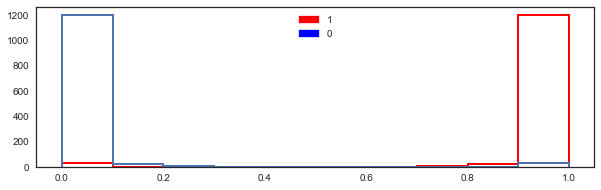

In [24]:
param_grid = [{'penalty': ['l2'], 'C': [0.1, 0.05, 0.01, 0.2, 0.5, 1],
               'fit_intercept': [True, False],
               'class_weight':['balanced',None]}]

lrc = LogisticRegression(random_state=3)
grid_search = GridSearchCV(lrc, param_grid, cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)

print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print("Best parameters:")
print(grid_search.best_params_)
print("\nBest estimator:")
print(grid_search.best_estimator_)
print("\nBest CV score:", grid_search.best_score_)

# best model
final_model_lg = grid_search.best_estimator_
# predictions
final_predictions = final_model_lg.predict_proba(X_test)

# plot probs
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(final_predictions[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(final_predictions[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
# legend
import matplotlib.patches as mpatches
pink_patch = mpatches.Patch(color='red', label='1')
green_patch = mpatches.Patch(color='blue', label='0')
plt.legend(handles=[pink_patch,green_patch], loc="upper center")
plt.show()

The best selection of parameters yields a F1 score of 0.78. Best model uses Ridge regularization with strength 0.1 (the smaller the stronger).

#### 3.3.2. Decision Tree

Now we'll try a Decision Tree. Again, we use `GridSearchCV` to evaluate hyperparameters using 5-fold cross validation:

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   20.2s finished


 ----------------- GRID_SEARCH INFO -----------------
 
Best parameters:
{'min_samples_leaf': 1, 'class_weight': 'balanced', 'splitter': 'random', 'max_features': None, 'max_depth': None, 'criterion': 'gini'}

Best estimator:
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='random')

Best CV score: 0.740996997355


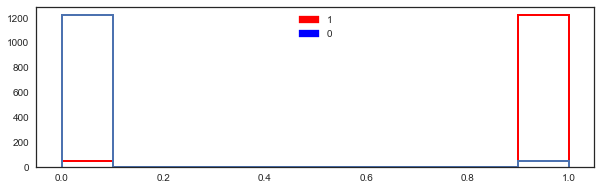

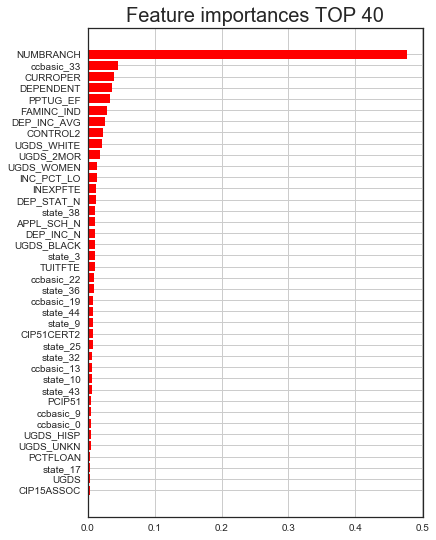

In [25]:
param_grid = [{'min_samples_leaf': [1,2],'max_depth':[None],
               'max_features':['auto',None], 'class_weight':['balanced'],
               'criterion':['gini','entropy'],'splitter':['best','random']}]


dtc = DecisionTreeClassifier(random_state=3)
grid_search = GridSearchCV(dtc, param_grid, cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)

print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print("Best parameters:")
print(grid_search.best_params_)
print("\nBest estimator:")
print(grid_search.best_estimator_)
print("\nBest CV score:", grid_search.best_score_)

# best model
final_model_dt = grid_search.best_estimator_
# predictions
final_predictions = final_model_dt.predict_proba(X_test)

# plot probs
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(final_predictions[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(final_predictions[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
# legend
import matplotlib.patches as mpatches
pink_patch = mpatches.Patch(color='red', label='1')
green_patch = mpatches.Patch(color='blue', label='0')
plt.legend(handles=[pink_patch,green_patch], loc="upper center")
plt.show()

# feature importance
feature_importances = final_model_dt.feature_importances_
indices = np.argsort(feature_importances)[::-1]
attributes = X_train.columns
fimpotances = sorted(zip(feature_importances, attributes), reverse=True)

# plot 50 most important features 
plt.figure(figsize=(6, 9))
plt.barh(range(40), feature_importances[indices][:40], color="r",
         align="center")
plt.yticks(range(40), [x[1] for x in fimpotances][:40])
plt.title("Feature importances TOP 40", size=20)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

The best model uses gini as the criterion for splitting. It doesn't prune the decision tree since the it allows a leaf contains one sample. We also see that the most important feature by far is `NUMBRANCH` although it doesn't mean that this is the only important feature due to potential correlation to other features. 

This model yields a F1 score of 0.74, which is not as good as that from Logistic Regression (0.78).

#### 3.3.3. SVM

We now try Support Vector Machines classification model. Again, `GridSearchCV` is used to evaluate hyperparameters:

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.6min finished


 ----------------- GRID_SEARCH INFO -----------------
 
Best parameters:
{'kernel': 'poly', 'C': 0.5, 'degree': 5, 'class_weight': 'balanced'}

Best estimator:
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=5, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=3, shrinking=True, tol=0.001,
  verbose=False)

Best CV score: 0.788260226827


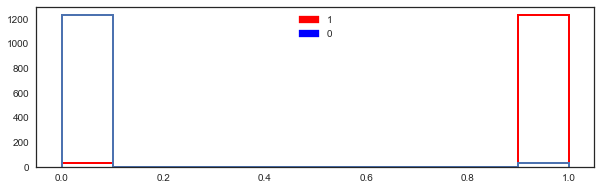

In [26]:
#param_grid = [{'C': [0.1,0.5,1], 'kernel': ['rbf','poly','sigmoid'],
#             'degree':[3,4],'class_weight':['balanced']}]
param_grid = [{'C': [0.5,1], 'kernel': ['poly'],
               'degree':[5,10],'class_weight':['balanced']}]

svmc = SVC(gamma='auto', probability=True, random_state=3)

grid_search = GridSearchCV(svmc,
                           param_grid,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)

print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print("Best parameters:")
print(grid_search.best_params_)
print("\nBest estimator:")
print(grid_search.best_estimator_)
print("\nBest CV score:", grid_search.best_score_)

# best model
final_model_svm = grid_search.best_estimator_
# predictions
final_predictions = final_model_svm.predict_proba(X_test)

# plot probs
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(final_predictions[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(final_predictions[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
# legend
import matplotlib.patches as mpatches
pink_patch = mpatches.Patch(color='red', label='1')
green_patch = mpatches.Patch(color='blue', label='0')
plt.legend(handles=[pink_patch,green_patch], loc="upper center")
plt.show()

The best set of parameters has a F1 score of 0.79, which makes it the best performing model so far. The model uses a polynomial kernel with 5 degrees, penalty parameter C as 0.5, and gamma as 1/132.

#### 3.3.4. Random Forest

Last model we are going to try is Random Forest (`GridSearchCV` with 5 folds):

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.0min remaining:   26.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


 ----------------- GRID_SEARCH INFO -----------------
 
Best parameters:
{'min_samples_leaf': 7, 'max_features': 'auto', 'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 600}

Best estimator:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

Best CV score: 0.836704610815


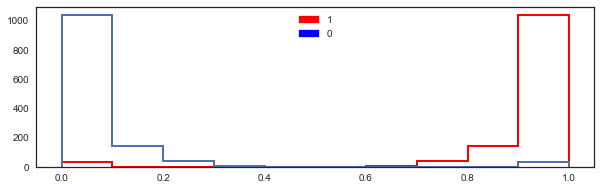

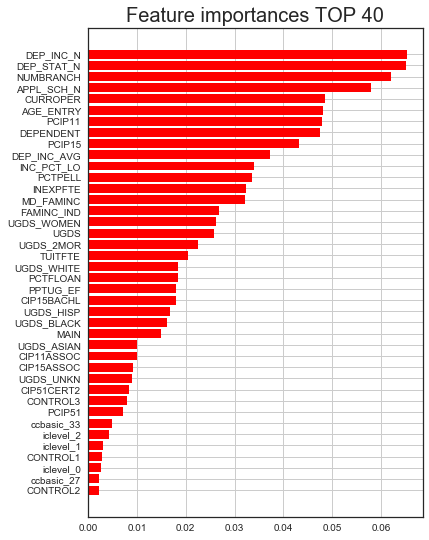

In [27]:
param_grid = [{'min_samples_leaf': [7,8], 'n_estimators': [600],
               'bootstrap': [True], 'max_features':['auto'],
               'class_weight':['balanced']}]


rfc = RandomForestClassifier(random_state=3)
grid_search = GridSearchCV(rfc, param_grid, cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)

print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print("Best parameters:")
print(grid_search.best_params_)
print("\nBest estimator:")
print(grid_search.best_estimator_)
print("\nBest CV score:", grid_search.best_score_)

# best model
final_model_rf = grid_search.best_estimator_
# predictions
final_predictions = final_model_rf.predict_proba(X_test)

# plot probs
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(final_predictions[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(final_predictions[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
# legend
import matplotlib.patches as mpatches
pink_patch = mpatches.Patch(color='red', label='1')
green_patch = mpatches.Patch(color='blue', label='0')
plt.legend(handles=[pink_patch,green_patch], loc="upper center")
plt.show()

# feature importance
feature_importances = final_model_rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
attributes = X_train.columns
fimpotances = sorted(zip(feature_importances, attributes), reverse=True)

# plot 50 most important features 
plt.figure(figsize=(6, 9))
plt.barh(range(40), feature_importances[indices][:40], color="r", align="center")
plt.yticks(range(40), [x[1] for x in fimpotances][:40])
plt.title("Feature importances TOP 40", size=20)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

Random forest yields the best score of all models with a 0.83 F1 score. The model creates 600 trees pruning the leaves with less than 7 samples. The importance of features is more balanced than that in the decision tree model.

#### 3.3.5. Metrics 

Looking at the F1 score is not enough to understand the behavior of our models. The F1 score gives us an overview of how precision and recall are doing. But in order to fully understand the models, we need to look at other metrics. The next cell introduces functions to plot several some of them:

* `plot_ROC_curve`: it will plot the receiver operating characteristic (ROC) curve which plots the true positive rate (sensitivity/recall) against the false positive rate. 

* `plot_PR_curve`:  it will plot precision against recall. 

* `plot_precision_recall_vs_threshold`:  It plots precision and recall against the probability decision. Good to see precision/recall trade off.

* `plot_confusion_matrix`: It plots the confusion matrix.

* `plot_scores`: It plots accuracy, F1, precision, recall, and true negative rate.

All functions have a boolean parameter (`train`) to indicate if we are working with train or test data:

* Train data: Stratified cross validation will be performed to get plots and metrics. Number of folds is also passed as a parameter (`n_folds`). 
* Test data: Model will be fit to all data to get plots and metrics. Ignores `n_folds` parameter.

In [34]:
def plot_ROC_curve(classifier, X, y, n_folds=4, train = True):
    """
    Plot a basic ROC curve of each fold + all folds.
    """    
    predictions_cv = pd.DataFrame({"class":y,"prediction":y,"probs":y})
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    
    if train:
        # stratified CV
        skf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=False)
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):        
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            # cv predictions and probs
            probas_ = (classifier.fit(X_train,
                                      y_train)).predict_proba(X_test)
            predictions_cv["probs"].loc[test_index] = probas_[:, 1]
            predictions_cv["prediction"].loc[test_index] = (classifier.fit(X_train,
                                                                           y_train)).predict(X_test)
            # ROC fold
            fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1],
                                             pos_label=1)
            plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, auc(fpr, tpr)))
    
    else:
        probas_ = classifier.predict_proba(X)
        predictions_cv["probs"] = probas_[:, 1]
        predictions_cv["prediction"] = classifier.predict(X)
            
    # ROC all folds
    fpr, tpr, thresholds = roc_curve(predictions_cv["class"], predictions_cv["probs"])
    if train:
        plt.plot(fpr, tpr, 'k--', lw=2, label='ROC (area = %0.2f)' % auc(fpr, tpr))
    else:
        plt.plot(fpr, tpr, 'k--', lw=2, label='ROC (area = %0.2f)' % auc(fpr, tpr))
    # random    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), lw=2, label='Random')
    # plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example',fontweight='bold')
    plt.legend(loc="lower right")
        
    return predictions_cv
 
    
def plot_PR_curve(classifier, X, y, n_folds=4, train = True):
    """
    Plot a basic precission/recall curve of each fold + all folds.
    """
    predictions_cv = pd.DataFrame({"class":y,"prediction":y,"probs":y})
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    
    if train:
        # stratified CV
        skf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=False)
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            # cv predictions and probs
            probas_ = (classifier.fit(X_train,
                                      y_train)).predict_proba(X_test)
            predictions_cv["probs"].loc[test_index] = probas_[:, 1]
            predictions_cv["prediction"].loc[test_index] = (classifier.fit(X_train,
                                                                           y_train)).predict(X_test)
            # P/C fold    
            precision, recall, thresholds = precision_recall_curve(y_test, probas_[:, 1])
            plt.plot(recall, precision, lw=1, label='PR fold %d' % (i,))
    else:
        probas_ = classifier.predict_proba(X)
        predictions_cv["probs"] = probas_[:, 1]
        predictions_cv["prediction"] = classifier.predict(X)
     
    # P/C all folds
    precision, recall, thresholds = precision_recall_curve(predictions_cv["class"],
                                                           predictions_cv["probs"])
    if train:
        plt.plot(recall, precision, 'k--', label='PR', lw=2)
    else:
        plt.plot(recall, precision, 'k--', lw=2)
    # plot tune up
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve', fontweight='bold')
    plt.legend(loc="lower left")
   
    return predictions_cv


def plot_precision_recall_vs_threshold(classifier, X, y, n_folds=4, train = True):
    """
    Plots precission/recall against threashold.
    """
    predictions_cv = pd.DataFrame({"class":y,"prediction":y,"probs":y})
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    
    if train:
        # stratified CV
        skf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=False)
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            # cv predictions and probs
            probas_ = (classifier.fit(X_train,
                                      y_train)).predict_proba(X_test)
            predictions_cv["probs"].loc[test_index] = probas_[:, 1]
            predictions_cv["prediction"].loc[test_index] = (classifier.fit(X_train,
                                                                           y_train)).predict(X_test)
    
    else:
        probas_ = classifier.predict_proba(X)
        predictions_cv["probs"] = probas_[:, 1]
        predictions_cv["prediction"] = classifier.predict(X)
    
    precisions, recalls, thresholds = precision_recall_curve(predictions_cv["class"],
                                                             predictions_cv["probs"])
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision",lw=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall",lw=2)
    plt.plot([0.5, 0.5], [0, 1], '--', color=(0.6, 0.6, 0.6), lw=1, label='0.5 threashold')
    plt.xlabel("Threshold")
    plt.legend(loc=8, bbox_to_anchor=(0.6, 0))
    plt.title("Precision/Recall tradeoff",fontweight='bold')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])


def plot_confusion_matrix(classifier, X, y, n_folds=4, train = True):
    """
    This function plots the confusion matrix. 
    Colored by normalized values.
    """
    normalize=True
    
    predictions_cv = pd.DataFrame({"class":y,"prediction":y,"probs":y})
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    
    if train:
        # stratified CV
        skf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=False)
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            probas_ = (classifier.fit(X_train,
                                      y_train)).predict_proba(X_test)
            predictions_cv["probs"].loc[test_index] = probas_[:, 1]
            predictions_cv["prediction"].loc[test_index] = (classifier.fit(X_train,
                                                                           y_train)).predict(X_test)
    else:
        probas_ = classifier.predict_proba(X)
        predictions_cv["probs"] = probas_[:, 1]
        predictions_cv["prediction"] = classifier.predict(X)
    
    cm = confusion_matrix(predictions_cv["class"],
                          predictions_cv["prediction"])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ia = plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", fontweight='bold')
    classes = predictions_cv["class"].unique()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j])+ " (" + str(round(cm_norm[i,j],2)) + ")",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=12)

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    cbar = plt.colorbar()
    
    
def plot_scores(classifier, X, y, n_folds=4, train = True):
    """
    Plots Accuracy, TNR, Recall (TPR), Precision, and F1 Score
    """    
    predictions_cv = pd.DataFrame({"class":y,"prediction":y,"probs":y})
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    
    if train:
        # stratified CV
        skf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=False)
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            probas_ = (classifier.fit(X_train,
                                      y_train)).predict_proba(X_test)
            predictions_cv["probs"].loc[test_index] = probas_[:, 1]
            predictions_cv["prediction"].loc[test_index] = (classifier.fit(X_train,
                                                                           y_train)).predict(X_test)

    else:
        probas_ = classifier.predict_proba(X)
        predictions_cv["probs"] = probas_[:, 1]
        predictions_cv["prediction"] = classifier.predict(X)
            
    cm = confusion_matrix(predictions_cv["class"], predictions_cv["prediction"])
    accuracy = accuracy_score(predictions_cv["class"], predictions_cv["prediction"])
    pr = precision_recall_fscore_support(predictions_cv["class"],
                                         predictions_cv["prediction"],
                                         average=None)[1]
    tnr = cm[1][1]/(cm[1][1]+cm[0][1])
    f1 = f1_score(predictions_cv["class"],
                  predictions_cv["prediction"],
                  average='binary' )
    precision  = precision_score(predictions_cv["class"],
                                 predictions_cv["prediction"],
                                 average='binary')
    score_names = ('Accuracy', 'TNR', 'Recall (TPR)', 'Precision', 'F1 Score')
    scores = [accuracy,(1-tnr),pr[1],precision,f1]
        
    y_pos = np.arange(len(scores))
    plt.barh(y_pos, scores, align='center', color='royalblue', ecolor='black')
    plt.yticks(y_pos, score_names,size=11)
    plt.grid(True,fillstyle='full')
    plt.xlim([0.0, 1.15])
    plt.title('Scores',fontweight='bold')
    for i, v in enumerate(scores):
        plt.text(v+0.01 , i , str(round(v,2)), color='black', size=11,fontweight='bold')

Now that we have our plotting functions we can assess our models by using the functions to plot all the metrics together for each model. We'll pass each final model select by `GridSearchCV` in the previous section to the plotting functions. We use 4 folds for cross validation on the training data (default options).

We start with the logistic regression model:

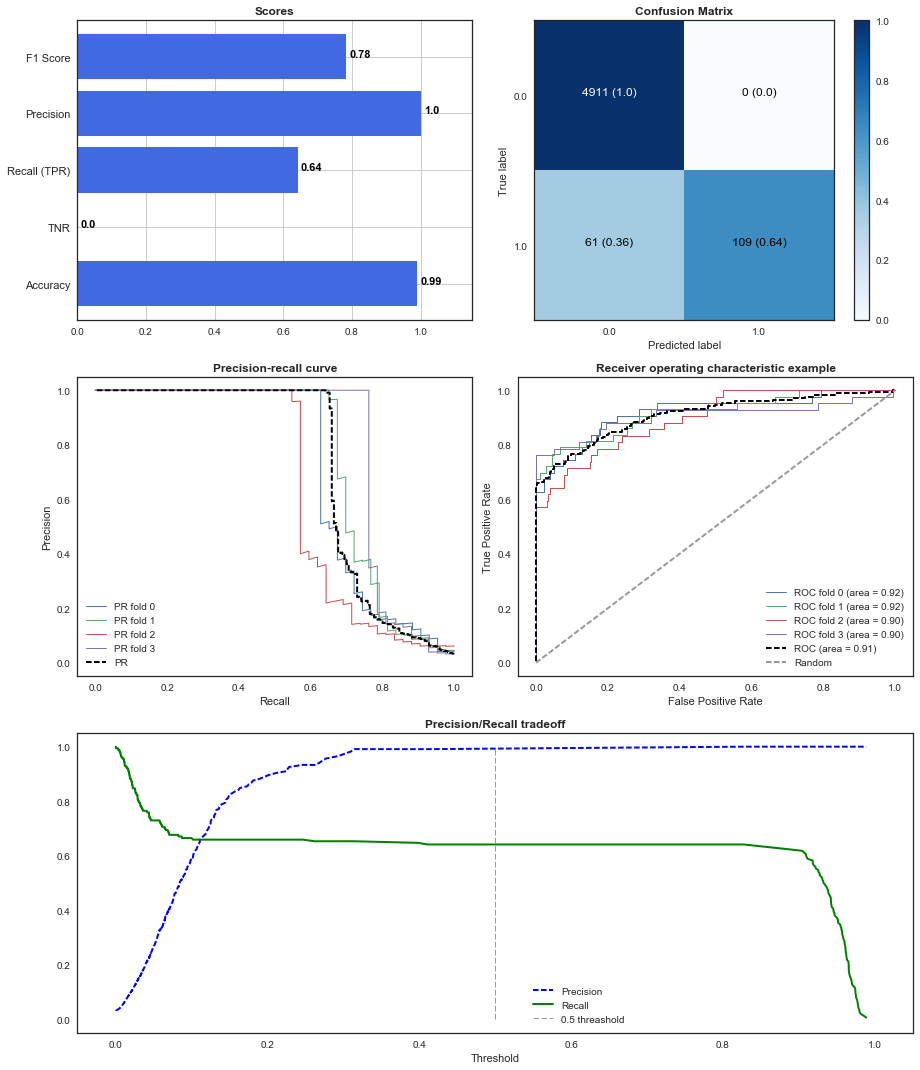

In [35]:
# logistic regression

plt.style.use('seaborn-white')
plt.rcParams['axes.facecolor'] = 'white'

fig = plt.figure(figsize=(19,15))

# SCORES
plt.subplot2grid((3,3), (0,0))
plot_scores(final_model_lg, X_train, y_train)

# CONFUSION MATRIX
plt.subplot2grid((3,3), (0,1))
plot_confusion_matrix(final_model_lg, X_train, y_train)

# PR CURVE
plt.subplot2grid((3,3), (1,0)) 
preds = plot_PR_curve(final_model_lg, X_train, y_train)

# ROC CURVE
plt.subplot2grid((3,3), (1,1))
b = plot_ROC_curve(final_model_lg, X_train, y_train)

# PR TRADEOFF
plt.subplot2grid((3,3), (2,0), colspan=2)
plot_precision_recall_vs_threshold(final_model_lg, X_train, y_train)


plt.tight_layout()
plt.show()

First thing we notice is that accuracy is not a good metric for a target varialbe with imbalanced classes. Here we have 99% accuracy but our true positive rate or recall is only 0.64. All of the 1s we predicted are true positives (100% precision) but we left some behind (36%).

In the precision/recall curve and ROC curve, we can see the curves for all of the folds (4). These curves are close together, indicating little variance. Thus, our model is robust. 

In the precision recall tradeoff plot, we can see that the threshold for our model is 0.5. Depending on what we try to achieve we could move this threshold to get different scores for precision/recall. 

Next, let's plot the decision tree metrics:

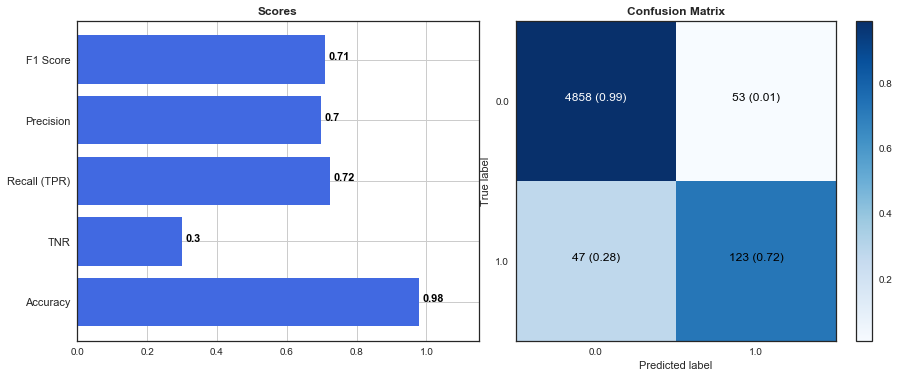

In [36]:
# decision tree

plt.style.use('seaborn-white')
plt.rcParams['axes.facecolor'] = 'white'

fig = plt.figure(figsize=(19,15))

# SCORES
plt.subplot2grid((3,3), (0,0))
plot_scores(final_model_dt, X_train, y_train)

# CONFUSION MATRIX
plt.subplot2grid((3,3), (0,1))
plot_confusion_matrix(final_model_dt, X_train, y_train)

plt.tight_layout()
plt.show()

With the decision tree we only show scores and confusion matrix. The decision tree didn't prune the leaves (`GridSearchCV` got the best score with this parameters), so there was only one element at each final leave. This means the probabilities are either 0 or 1 (same as the predictions) because the probabilities are the fraction of samples of the same class in a leaf.

From the metrics we can see that it gets better recall than logistic regression but worst precision.

Next let's plot the SVM:

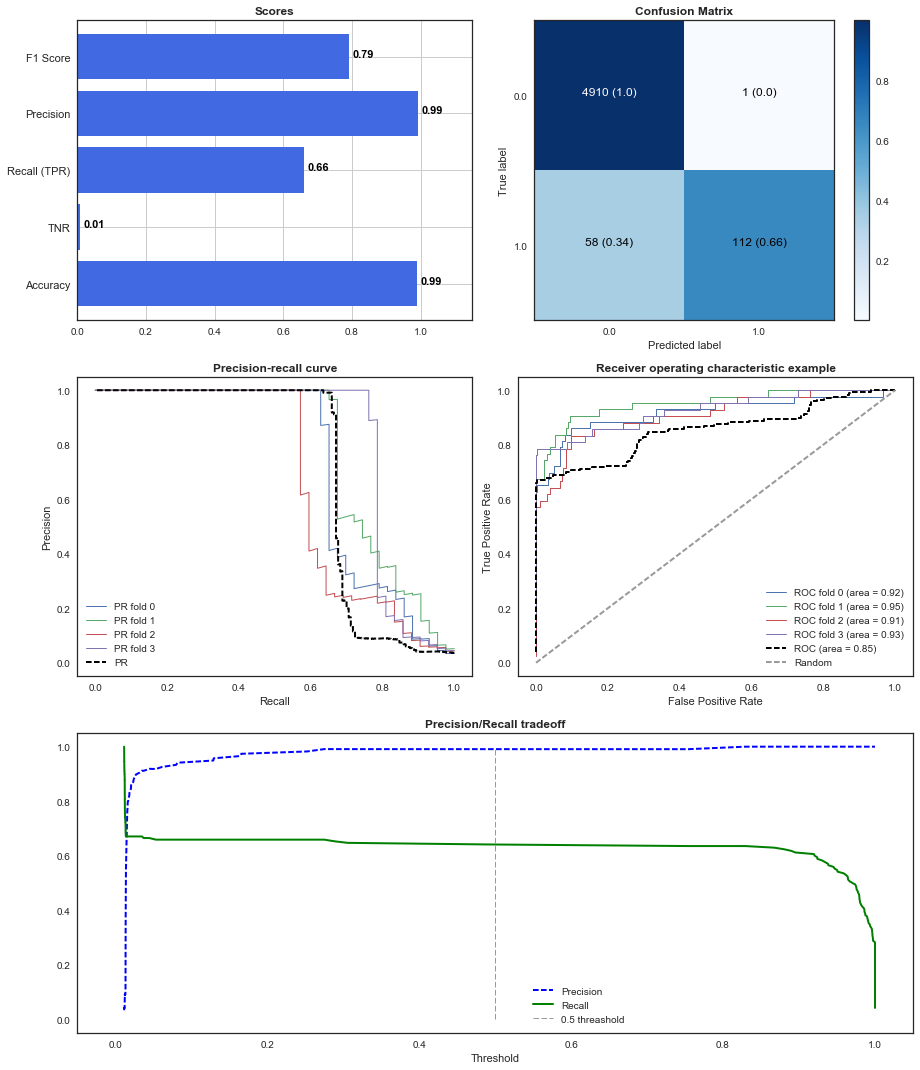

In [37]:
# SVM

plt.style.use('seaborn-white')
plt.rcParams['axes.facecolor'] = 'white'

fig = plt.figure(figsize=(19,15))

# SCORES
plt.subplot2grid((3,3), (0,0))
plot_scores(final_model_svm, X_train, y_train)

# CONFUSION MATRIX
plt.subplot2grid((3,3), (0,1))
plot_confusion_matrix(final_model_svm, X_train, y_train)

# PR CURVE
plt.subplot2grid((3,3), (1,0)) 
preds = plot_PR_curve(final_model_svm, X_train, y_train)

# ROC CURVE
plt.subplot2grid((3,3), (1,1))
b = plot_ROC_curve(final_model_svm, X_train, y_train)

# PR TRADEOFF
plt.subplot2grid((3,3), (2,0), colspan=2)
plot_precision_recall_vs_threshold(final_model_svm, X_train, y_train)


plt.tight_layout()
plt.show()

SVM classifier does better than logistic regression with higher recall, which means we are classifying better the class 1s (more true positives).  Precision is not perfect though, one sample is misclassified.

Next let's plot the Random Forest metrics:

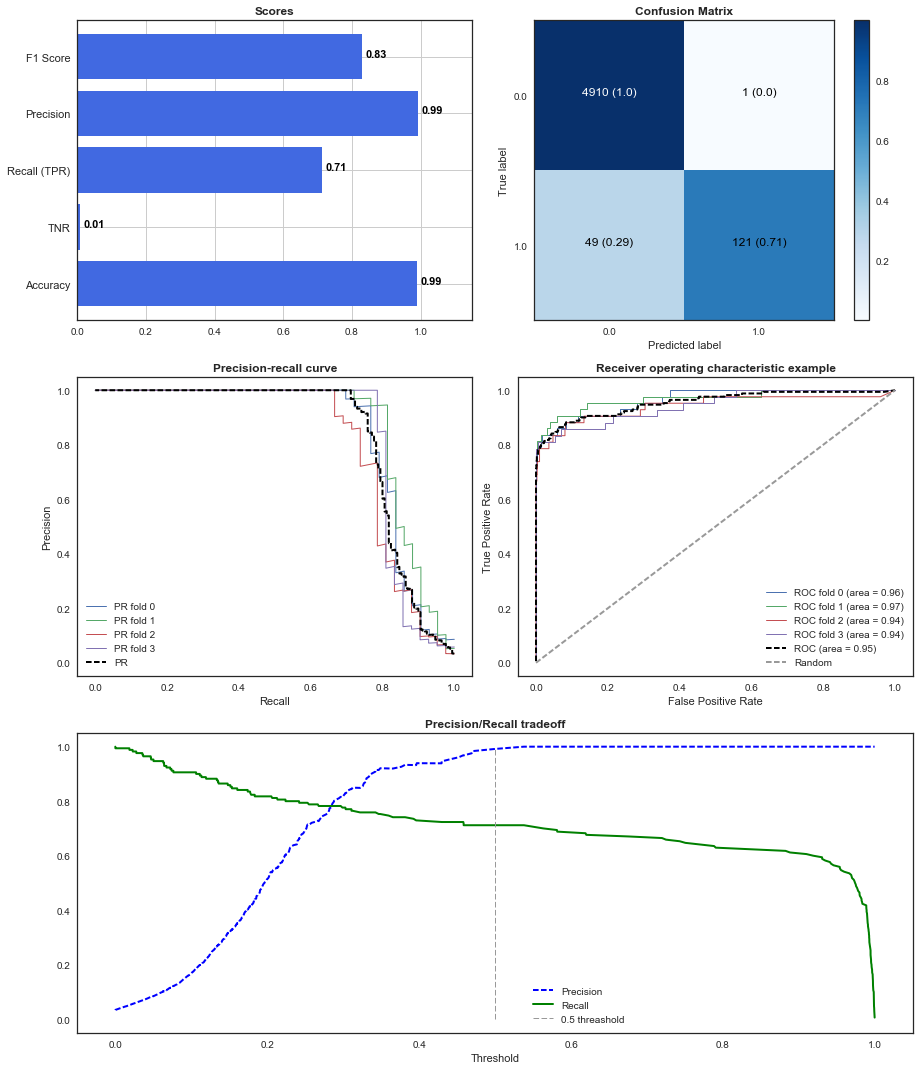

In [38]:
# Random forest

plt.style.use('seaborn-white')
plt.rcParams['axes.facecolor'] = 'white'

fig = plt.figure(figsize=(19,15))

# SCORES
plt.subplot2grid((3,3), (0,0))
plot_scores(final_model_rf, X_train, y_train)

# CONFUSION MATRIX
plt.subplot2grid((3,3), (0,1))
plot_confusion_matrix(final_model_rf, X_train, y_train)

# PR CURVE
plt.subplot2grid((3,3), (1,0)) 
preds = plot_PR_curve(final_model_rf, X_train, y_train)

# ROC CURVE
plt.subplot2grid((3,3), (1,1))
b = plot_ROC_curve(final_model_rf, X_train, y_train)

# PR TRADEOFF
plt.subplot2grid((3,3), (2,0), colspan=2)
plot_precision_recall_vs_threshold(final_model_rf, X_train, y_train)


plt.tight_layout()
plt.show()

Random Forest is clearly the best performing model for this classification task. It has perfect almost precision and a very high recall (0.71). Furthermore, the precision/recall and ROC curve folds are closer that in the other models, thus, this model is more robust than the rest. We'll keep this model as our final model.

### 3.5. Final model

After evaluating all metrics above we selected Random Forest as our final model. Now we want to see how the model performs on unseen data. To assess the final performance we'll plot all metrics using the test set (`train=False`):

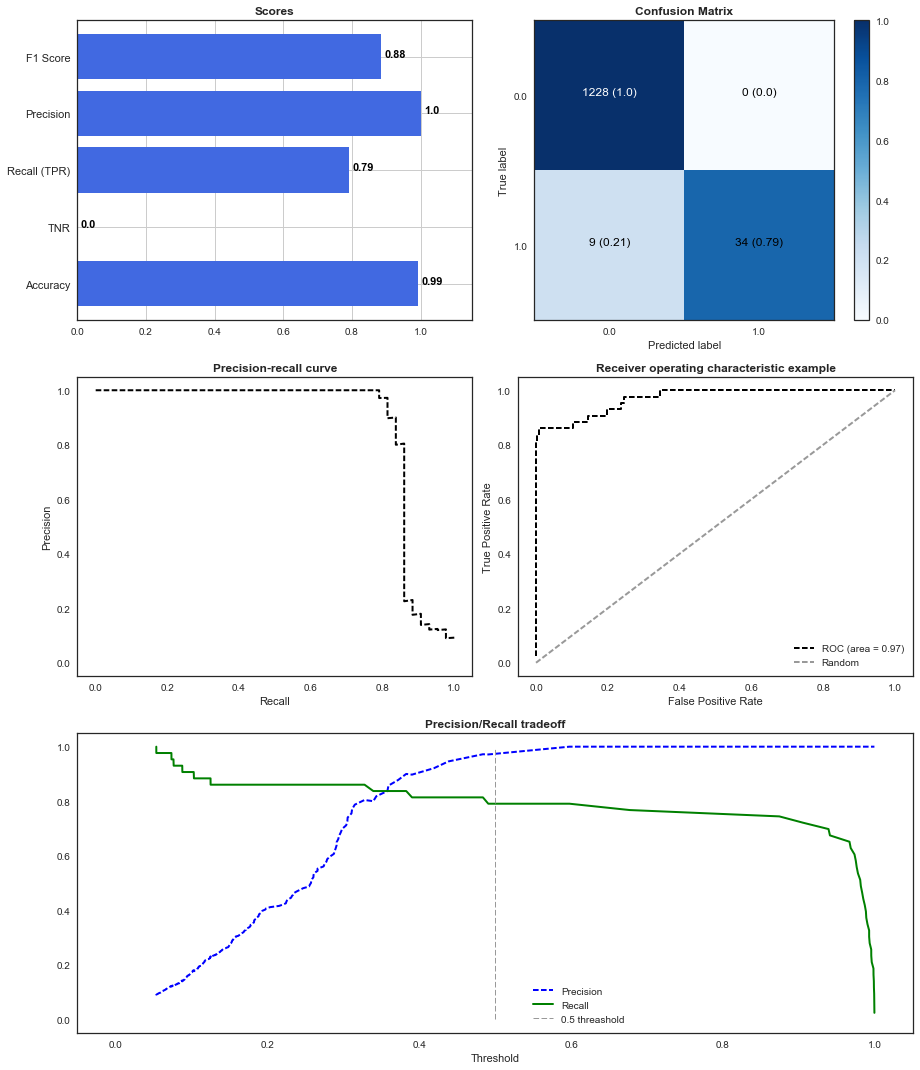

In [39]:
# Final model - Random Forest - test set

plt.style.use('seaborn-white')
plt.rcParams['axes.facecolor'] = 'white'

fig = plt.figure(figsize=(19,15))

# SCORES
plt.subplot2grid((3,3), (0,0))
plot_scores(final_model_rf, X_test, y_test, train=False)


# CONFUSION MATRIX
plt.subplot2grid((3,3), (0,1))
plot_confusion_matrix(final_model_rf, X_test, y_test, train=False)

# PR CURVE
plt.subplot2grid((3,3), (1,0)) 
preds = plot_PR_curve(final_model_rf, X_test, y_test, train=False)

# ROC CURVE
plt.subplot2grid((3,3), (1,1))
b = plot_ROC_curve(final_model_rf, X_test, y_test, train=False)

# PR TRADEOFF
plt.subplot2grid((3,3), (2,0), colspan=2)
plot_precision_recall_vs_threshold(final_model_rf, X_test, y_test, train=False)


plt.tight_layout()
plt.show()

The model on the unseen data performed slightly better than it did on the training data set. The difference is not very big, indicating the model is robust. 

### 3.6. Additional comments

- Depending on what we want to achive with the classification, we could change the threahold to obtain different results. We can see how chaging the threshold will affect the metrics by inspecting the plots.

### The end